# Python-in-the-lab: functions and data fitting II

In [1]:
import os
import numpy as np
import scipy.integrate as integrate
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
mainDir = "/home/gf/src/Python/Python-in-the-lab/Bk"
# Today we use the same file of the shapes
filename = "F64ac_0.02_time_V_T.dat"
filename = os.path.join(mainDir, filename)
data = np.loadtxt(filename, comments="#")
time = data[:,0]
with open(filename) as f:
    header = f.readline()
durations = [float(duration) for duration in header.split()[1:]]
shapes = dict()
for i, duration in enumerate(durations):
    shapes[duration] = data[:,i+1]

## Next Problem
## 1. Make the average of the 8 normalized curves (repeted here)

In [3]:
# Get the average of the 8 curves
#average = np.zeros_like(shapes[size]) # Ahah, this is not required!
average = 0
for duration in shapes:
    shape = shapes[duration]
    average += shape/integrate.trapz(shape,time)
average /= len(shapes)

(0, 1, 0, 1.55)

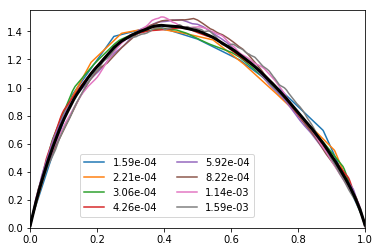

In [4]:
# Replot for comparison with the average
for size in sorted(shapes):
    lb = "{0:.2e}".format(size)
    shape = shapes[size]
    norm = integrate.trapz(shapes[size], time)
    plt.plot(time, shapes[size]/norm, label=lb)
plt.legend(ncol=2,loc=(0.15,.05))
plt.plot(time, average, 'k', lw=3)
plt.axis((0,1,0,1.55))

## 2. Make a fit of the average curve with 
## $[x(1-x)]^{\gamma -1} * exp(-Ax)$, 

## with $A, \gamma$ as fitting parameters. 

In [5]:
# Introduction to functions and fitting function
parameters = ["gamma", "A"]
def fitShape(x, gamma, a):
    """
    fitting function for the average shape
    
    Parameters:
    ===========
    a: float
        constant of the exponential
    gamma: float
        exponent of the shape
    """
    f = (x*(1-x))**(gamma-1) * np.exp(-a * x)
    norm = integrate.trapz(f, x)
    return f/norm

from scipy.optimize import curve_fit
popt, pcov = curve_fit(fitShape, time, average)
for p, diag, parameter in zip(popt,pcov.diagonal(),parameters):
    print("Parameter {0} = {1:.3f} +/- {2:.3f}".format(parameter, p, diag**0.5))
#pcov.diagonal()**0.5 # These are the errors of the fitting parameters at 1 sigma

Parameter gamma = 1.802 +/- 0.001
Parameter A = 0.549 +/- 0.002


Text(0, 0.5, 'average shape (normalized)')

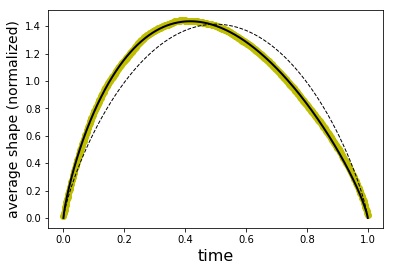

In [6]:
plt.plot(time, average, 'yo')
plt.plot(time, fitShape(time, *popt), '-k', lw=2) # Note the use of *popt
plt.plot(time, fitShape(time, popt[0], 0), '--k', lw=1) # What did I do?
plt.xlabel("time", size=16)
plt.ylabel("average shape (normalized)", size=14)

# Fitting is so important in the lab... let's explore it a little bit

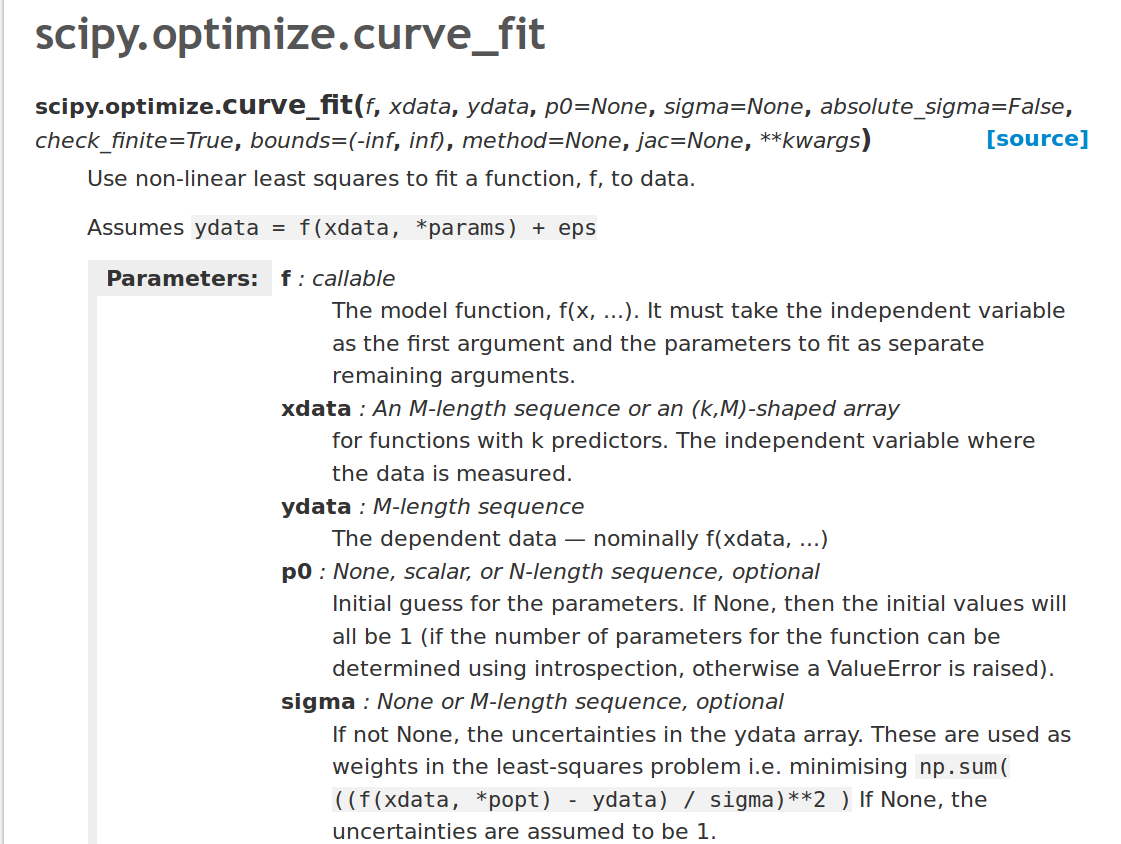

In [7]:
from IPython.display import Image
imageDir = "/home/gf/src/Python/Python-in-the-lab/images"
Image(filename=os.path.join(imageDir,'curve_fit1.png'))

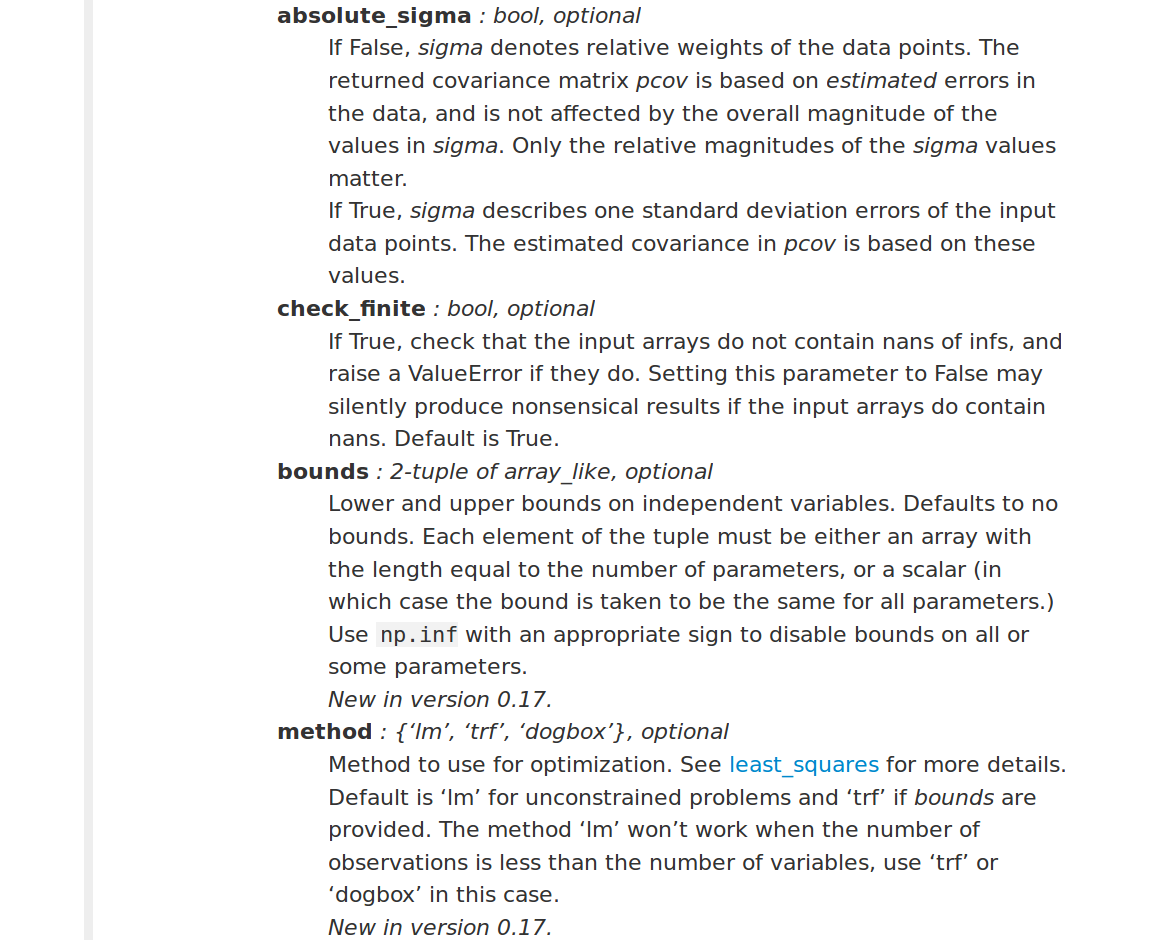

In [8]:
Image(filename=os.path.join(imageDir,'curve_fit2.png'))

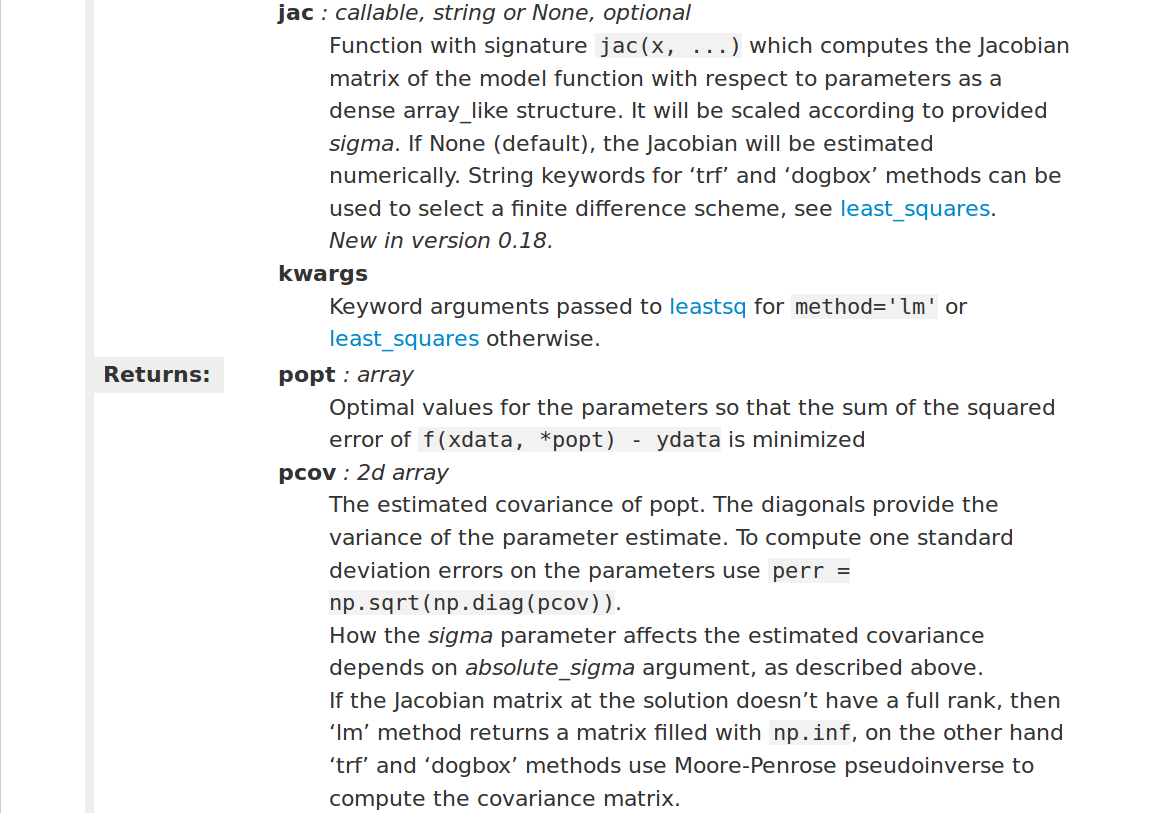

In [9]:
Image(filename=os.path.join(imageDir,'curve_fit3.png'))

# Ok, man, this is a serious problem

I am doing an average over 8 curves, I think I can estimate an error bar for each point, can I?

But then should I use it for doing what? Weight or error? And...

*Does the fitting parameters and their errors depend on this choice???*

### Problem: calculate the error bars, and use them in the fitting fuction. Show if the fitting parameters change and their error

_Reminder: the variance of the average is the variance of the data over the number of data_
$\sigma^2_\bar{x} = \sigma_x^2/N$

Parameter gamma = 1.8196 +/- 0.0021
Parameter A = 0.5216 +/- 0.0047
Parameter gamma = 1.8196 +/- 0.0014
Parameter A = 0.5216 +/- 0.0032


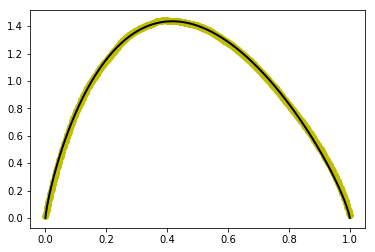

In [10]:
# The solution goes here...
rows, cols = data.shape
# Let's calculate the variances of the original data
variances = np.var(data[:,1:], axis=1)
err_average = (variances / (cols - 1))**0.5
# Sigma as weigths
popt1, pcov1 = curve_fit(fitShape, time, average, p0=(1.6,0.5), sigma=err_average)
# print the results
for p, diag, parameter in zip(popt1,pcov1.diagonal(),parameters):
    print("Parameter {0} = {1:.4f} +/- {2:.4f}".format(parameter, p, diag**0.5))
# Plot the average and the fit
plt.plot(time, average, 'yo')
plt.plot(time, fitShape(time, *popt), '-k', lw=2) # Note the use of *popt
# Sigma as uncertainties 
popt2, pcov2 = curve_fit(fitShape, time, average, p0=(1.6,0.5), 
                         sigma=err_average, absolute_sigma=True)
for p, diag, parameter in zip(popt2,pcov2.diagonal(),parameters):
    print("Parameter {0} = {1:.4f} +/- {2:.4f}".format(parameter, p, diag**0.5))

**Oh, we did an error: we calculated the variances over the original data, not on the normalized shapes.**

**How can we solve this problem?
We can redo the calculus adding the normalization, but it is better to define a normalized set of data**


Parameter gamma = 1.8181 +/- 0.0061
Parameter A = 0.5319 +/- 0.0136


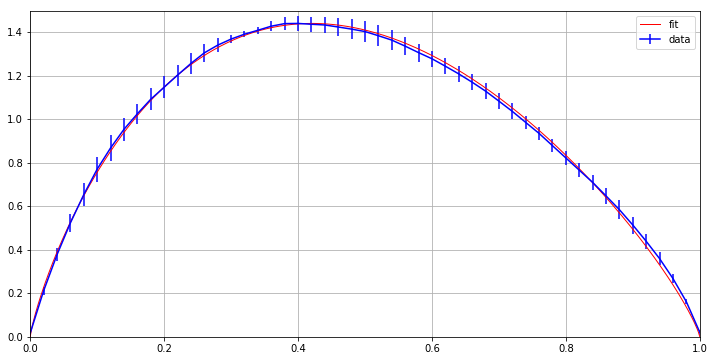

In [17]:
# Let's introduce the apply_along_axis
# and the calculus along an axis
norms = np.apply_along_axis(integrate.trapz, 0, data[:,1:], time)
data_norm = data[:,1:] / norms
average_normed = data_norm.mean(axis=1)
# Can we calculate the sigmas (error bars) in the same way?
rows, cols = data_norm.shape
sigmas = data_norm.std(axis=1)/cols**0.5

fig,ax = plt.subplots(1,1,figsize=(12,6))
_step = 10
ax.errorbar(time[::_step], average_normed[::_step], 3*sigmas[::_step], 
            fmt="b-", ecolor='b', label="data")
ax.grid(True)
ax.axis((0,1,0,1.5))
popt2, pcov2 = curve_fit(fitShape, time, average_normed, p0=(1.6,0.5), sigma=3*sigmas)
ax.plot(time, fitShape(time, *popt2), '-r', lw=1, label="fit") # Note the use of *popt2
ax.legend()
for p, diag, par in zip(popt2,pcov2.diagonal(),parameters):
    print("Parameter {0} = {1:.4f} +/- {2:.4f}".format(par, p, 3*diag**0.5))

# How to use the information on the uncertainties

All data have uncertainties. Something they are difficult to estimate, so one assume that they are negligible. Data have all the same weight, and the error in the parameters is calculated considering the "distance" between the fitting function and the data. *Case "No weigths"*

If the uncertainties are available, they can be used to _weight_ the data, i.e. the larger the uncertainties the less the importance of the point. *Case Just weigths*

The uncertainties can be used as weights *and* error of the data: the fitted parameters are the same as before, but not their errors. *Case: Weights and error bars*

In [12]:
print("No weights")
popt, pcov = curve_fit(fitShape, time, average_normed)
for p, diag, par in zip(popt,pcov.diagonal(),parameters):
    print("Parameter {0} = {1:.4f} +/- {2:.4f}".format(par, p, diag**0.5))
print(35*"*")
print("Just weights")
popt_w, pcov_w = curve_fit(fitShape, time, average_normed, sigma=3*sigmas)
for p, diag, par in zip(popt_w,pcov_w.diagonal(),parameters):
    print("Parameter {0} = {1:.4f} +/- {2:.4f}".format(par, p, diag**0.5))
print(35*"*")
print("Weights and error bars")
popt_we, pcov_we = curve_fit(fitShape, time, average, sigma=3*sigmas, absolute_sigma=True)
for p, diag, par in zip(popt_we,pcov_we.diagonal(),parameters):
    print("Parameter {0} = {1:.4f} +/- {2:.4f}".format(par, p, diag**0.5))

No weights
Parameter gamma = 1.8018 +/- 0.0015
Parameter A = 0.5487 +/- 0.0024
***********************************
Just weights
Parameter gamma = 1.8181 +/- 0.0020
Parameter A = 0.5319 +/- 0.0045
***********************************
Weights and error bars
Parameter gamma = 1.8181 +/- 0.0031
Parameter A = 0.5319 +/- 0.0068


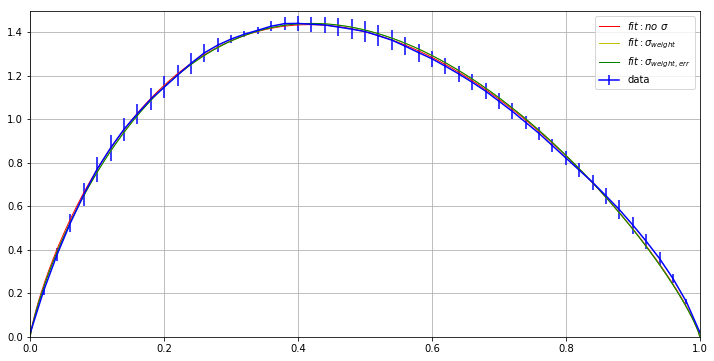

In [13]:
# Let's the difference
fig,ax = plt.subplots(1,1,figsize=(12,6))
_step = 10
ax.errorbar(time[::_step], average_normed[::_step], 3*sigmas[::_step], 
            fmt="b-", ecolor='b', label="data")
ax.plot(time, fitShape(time, *popt), '-r', lw=1, label=r"$fit: no \ \sigma$")
ax.plot(time, fitShape(time, *popt_w), '-y', lw=1, label=r"$fit: \sigma_{weight}$")
ax.plot(time, fitShape(time, *popt_we), '-g', lw=1, label=r"$fit: \sigma_{weight,err}$")
ax.grid(True)
ax.axis((0,1,0,1.5))
ax.legend();

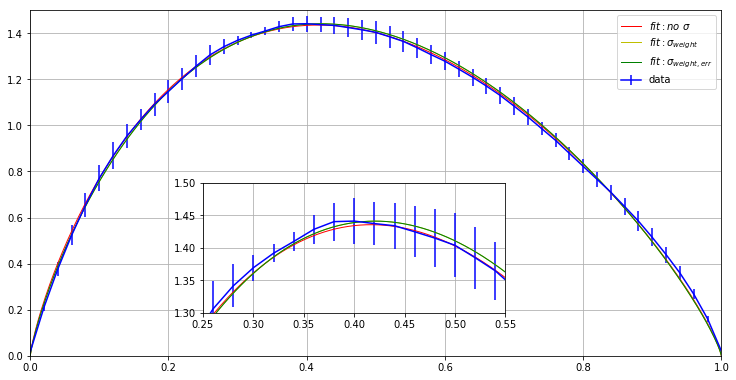

In [14]:
# Let's the difference
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # left, bottom, width, height (range 0 to 1)
ax2 = fig.add_axes([0.3, 0.2, 0.35, 0.3]) # to zoom

_step = 10
for ax in [ax1,ax2]:
    ax.errorbar(time[::_step], average_normed[::_step], 3*sigmas[::_step], 
            fmt="b-", ecolor='b', label="data")
    ax.plot(time, fitShape(time, *popt), '-r', lw=1, label=r"$fit: no \ \sigma$")
    ax.plot(time, fitShape(time, *popt_w), '-y', lw=1, label=r"$fit: \sigma_{weight}$")
    ax.plot(time, fitShape(time, *popt_we), '-g', lw=1, label=r"$fit: \sigma_{weight,err}$")
    ax.grid(True)
ax1.axis((0,1,0,1.5))
ax1.legend()
ax2.axis((0.25,.55,1.3,1.5));

In [15]:
fig.add_axes?